# Introduction
[Data Description](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data)


You are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:
```
toxic
severe_toxic
obscene
threat
insult
identity_hate
```
You must create a model which predicts a probability of each type of toxicity for each comment.


# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (12,8)})
plt.style.use('ggplot') # better than sns styles.
matplotlib.rcParams['figure.figsize'] = 12,8

import os
import time

# random state
SEED=100
np.random.seed(SEED)

# Jupyter notebook settings for pandas
#pd.set_option('display.float_format', '{:,.2g}'.format) # numbers sep by comma
from pandas.api.types import CategoricalDtype
np.set_printoptions(precision=3)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100) # None for all the rows
pd.set_option('display.max_colwidth', 500)

import IPython
from IPython.display import display, HTML, Image, Markdown

print([(x.__name__,x.__version__) for x in [np, pd,sns,matplotlib]])

[('numpy', '1.17.4'), ('pandas', '0.25.3'), ('seaborn', '0.9.0'), ('matplotlib', '3.1.1')]


In [0]:
import re
import string # string.punctuation
import string
from string import digits

In [3]:
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
ENV_BHISHAN = None

try:
    import bhishan
    ENV_BHISHAN = True
    print("Environment: Bhishan's Laptop")
except:
    pass


import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    # load google drive
    # from google.colab import drive
    # drive.mount('/content/drive')
    # dat_dir = 'drive/My Drive/Colab Notebooks/data/' 
    # sys.path.append(dat_dir)
    
    # pip install
    #!pip install pyldavis
    #!pip install hyperopt
    #!pip install catboost

    # upgrade tqdm and restart to use df.progess_apply()
    !pip install -U tqdm
    
    # print
    print('Environment: Google Colaboratory.')


Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.39.0)
Environment: Google Colaboratory.


In [0]:
from tqdm.notebook import trange, tqdm

# I need to upgrade tqdm and restart google colab to use df.progress_apply()

# Useful Scripts

In [0]:
def show_method_attributes(obj, ncols=7,start=None, inside=None):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_method_attributes(list)
     """

    print(f'Object Type: {type(obj)}\n')
    lst = [elem for elem in dir(obj) if elem[0]!='_' ]
    lst = [elem for elem in lst 
           if elem not in 'os np pd sys time psycopg2'.split() ]

    if isinstance(start,str):
        lst = [elem for elem in lst if elem.startswith(start)]
        
    if isinstance(start,tuple) or isinstance(start,list):
        lst = [elem for elem in lst for start_elem in start
               if elem.startswith(start_elem)]
        
    if isinstance(inside,str):
        lst = [elem for elem in lst if inside in elem]
        
    if isinstance(inside,tuple) or isinstance(inside,list):
        lst = [elem for elem in lst for inside_elem in inside
               if inside_elem in elem]

    return pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')

# Load the Data

In [6]:
ifile1 = '../data/raw/train.csv'
ifile2 = 'https://github.com/bhishanpdl/Project_Toxic_Comments/blob/master/data/raw/train.csv?raw=true'

if ENV_BHISHAN:
    df_raw = pd.read_csv(ifile1)


if ENV_COLAB:
    df_raw = pd.read_csv(ifile2)
    pass


df = df_raw.copy()

print(df.isnull().sum().sum())
print(df.shape)
display(df.head(2))

0
(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0


In [7]:
df['clean'] = df.loc[:,'toxic':'identity_hate'].sum(axis=1) == 0

print(df['clean'].sum())

df.head(2)

143346


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0,True
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0,True


# Class distribution

In [8]:
ser_sum = df.iloc[:,2:].sum(axis=0)
ser_sum

toxic             15294.0
severe_toxic       1595.0
obscene            8449.0
threat              478.0
insult             7877.0
identity_hate      1405.0
clean            143346.0
dtype: float64

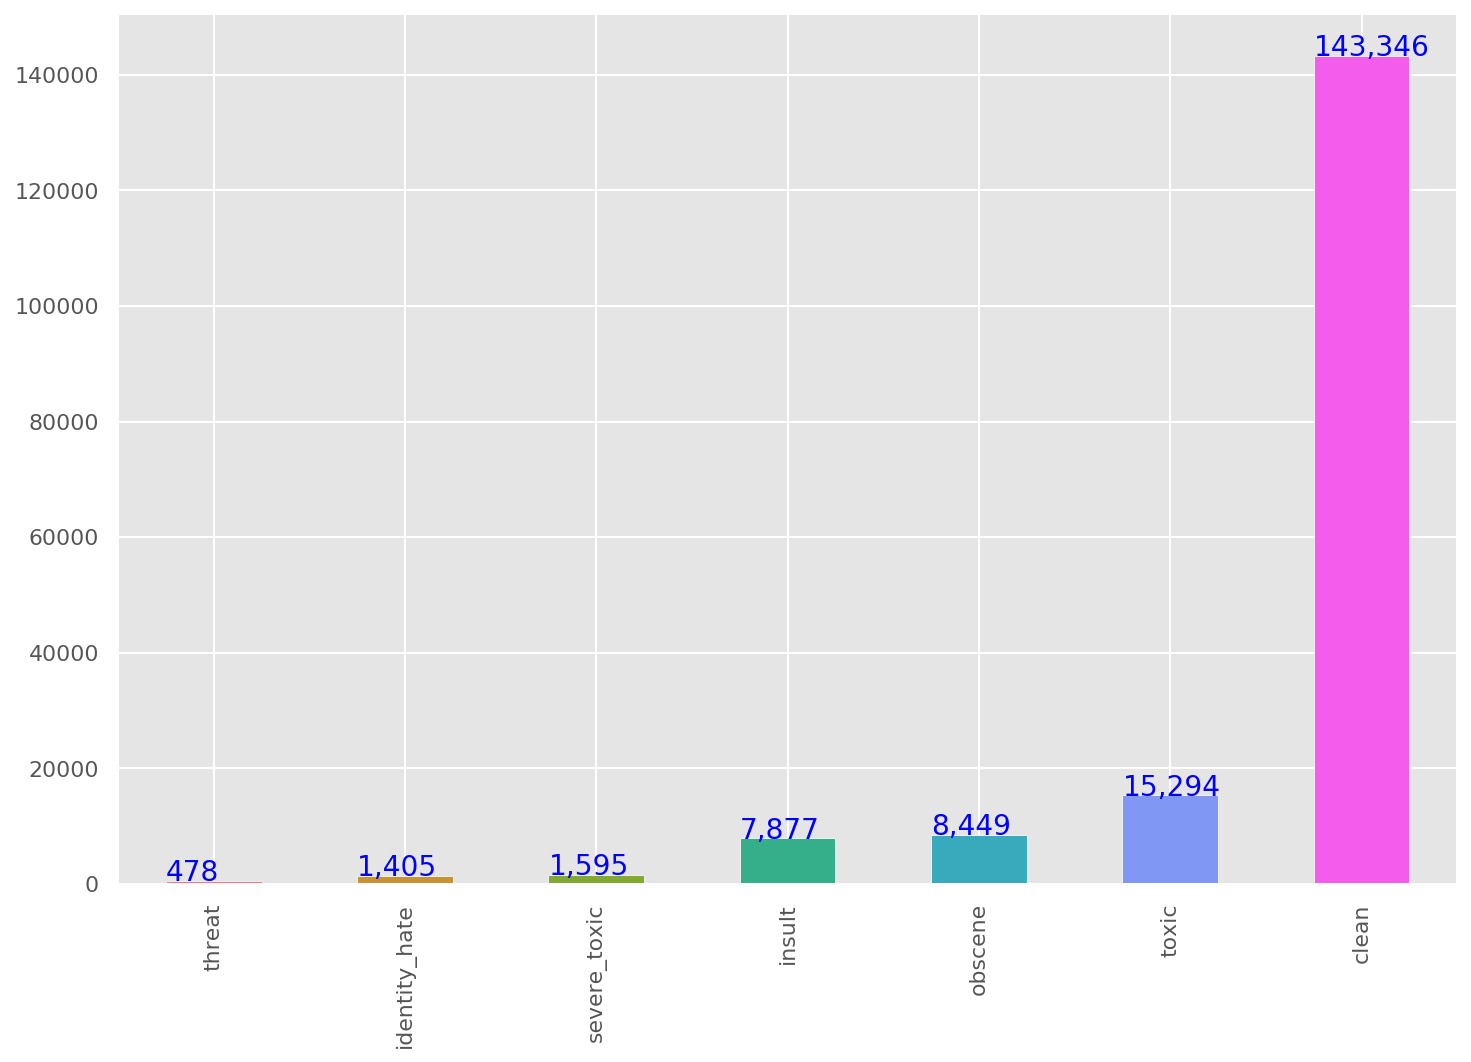

In [9]:
ax = ser_sum.sort_values().plot.bar(color=sns.color_palette('husl',len(ser_sum)))

for p in ax.patches:
    x,y = p.get_x(), p.get_height()
    ax.text(x,y,f'{y:,.0f}',fontsize=14,color='blue')

# Select only text column

In [10]:
tqdm.pandas()
ser_comments = df['comment_text'].progress_apply(nltk.word_tokenize)

100%|██████████| 159571/159571 [01:48<00:00, 1469.44it/s]


In [12]:
ser_comments.head()

0                                                                                                                                                                                       [Explanation, Why, the, edits, made, under, my, username, Hardcore, Metallica, Fan, were, reverted, ?, They, were, n't, vandalisms, ,, just, closure, on, some, GAs, after, I, voted, at, New, York, Dolls, FAC, ., And, please, do, n't, remove, the, template, from, the, talk, page, since, I, 'm, retired, now.89.205.38.27]
1                                                                                                                                                                                                                                                                                                                                                                  [D'aww, !, He, matches, this, background, colour, I, 'm, seemingly, stuck, with, ., Thanks, ., (, talk, ), 21:51, ,, January, 11, ,, 2016, (

In [13]:
ser_comments.shape, df.shape

((159571,), (159571, 9))

In [0]:
# ser_comments[0]

# Check nans and duplicates

In [16]:
df[df['comment_text']==''].shape

(0, 9)

In [17]:
df[df.comment_text.duplicated()].shape

(0, 9)

# Separate the classes

In [0]:
toxic = df[df.toxic == 1]['comment_text'].to_numpy()
severe_toxic = df[df.severe_toxic == 1]['comment_text'].to_numpy()
obscene = df[df.obscene == 1]['comment_text'].to_numpy()
threat = df[df.threat == 1]['comment_text'].to_numpy()
insult = df[df.insult == 1]['comment_text'].to_numpy()
identity_hate = df[df.identity_hate == 1]['comment_text'].to_numpy()

# Word clouds

In [0]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS

In [0]:
# !wget https://raw.githubusercontent.com/bhishanpdl/Project_Toxic_Comments/master/images/twitter.png

In [0]:
def wordcloud_plot(text_arr, name) : 
    plt.figure(figsize=(12,8))

    wc = WordCloud(background_color="black",
                   max_words=500,mask=None,
                   min_font_size=6,
                   stopwords=stopwords,
                   max_font_size= 60)
    
    wc.generate(" ".join(text_arr))
    plt.title("Twitter Wordlcloud " + name +  " Comments", fontsize=30)
    # plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
    plt.imshow(wc.recolor( colormap= 'Set1' , random_state=21), alpha=0.98)
    plt.axis('off')
    plt.savefig(name+'_wc.png')
    return

True

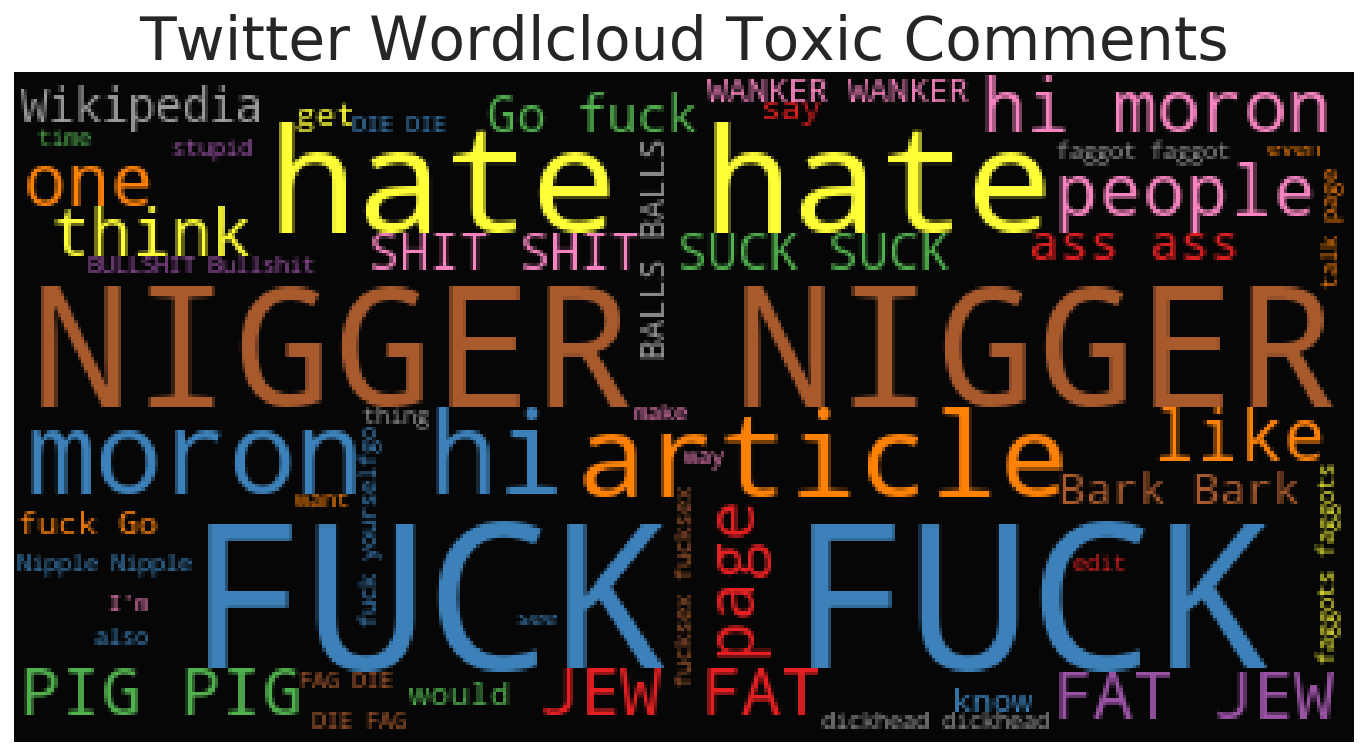

In [69]:
wordcloud_plot(toxic, "Toxic")

# Treat the apostrophes

References:
- [GKeng](https://www.kaggle.com/gakngm/data-analysis-toxic-comments/notebook)

In [0]:
replacement_patterns = [
 (r'won\'t', 'will not'),
 (r'can\'t', 'cannot'),
 (r'i\'m', 'i am'),
 (r'ain\'t', 'is not'),
 (r'(\w+)\'ll', '\g<1> will'),
 (r'(\w+)n\'t', '\g<1> not'),
 (r'(\w+)\'ve', '\g<1> have'),
 (r'(\w+)\'s', '\g<1> is'),
 (r'(\w+)\'re', '\g<1> are'),
 (r'(\w+)\'d', '\g<1> would')
]
class RegexpReplacer(object):
    def __init__(self, patterns=replacement_patterns):
         self.patterns = \
         [(re.compile(regex), repl) for (regex, repl) in patterns]
     
    def replace(self, text):
        s = text
        for (pattern, repl) in self.patterns:
             s = re.sub(pattern, repl, s)
        return s

In [0]:
from tqdm.notebook import trange
import string

lemmatizer = nltk.stem.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
tokenizer = nltk.tokenize.TweetTokenizer()

replacer = RegexpReplacer()


def process_text_arr(arr):
    arr_processed = []

    for i in trange(arr.shape[0]):
        # tokenize
        lst = tokenizer.tokenize(replacer.replace(arr[i]))

        # remove stopwords
        lst = [word for word in lst
                     if (word.lower() not in stopwords
                                      and word.lower() 
                                      not in list(string.punctuation))]

        lst = [ lemmatizer.lemmatize(word, 'v') for word in lst]
        arr_processed.extend(list(lst))
    return arr_processed

In [50]:
toxic1 = process_text_arr(toxic)

# Frequency Distribution

In [0]:
fd = nltk.FreqDist(word for word in toxic1)

In [52]:
show_method_attributes(fd)

Object Type: <class 'nltk.probability.FreqDist'>



,0,1,2,3,4,5,6
0,B,copy,get,max,pop,setdefault,unicode_repr
1,N,elements,hapaxes,most_common,popitem,subtract,update
2,Nr,freq,items,pformat,pprint,tabulate,values
3,clear,fromkeys,keys,plot,r_Nr,,


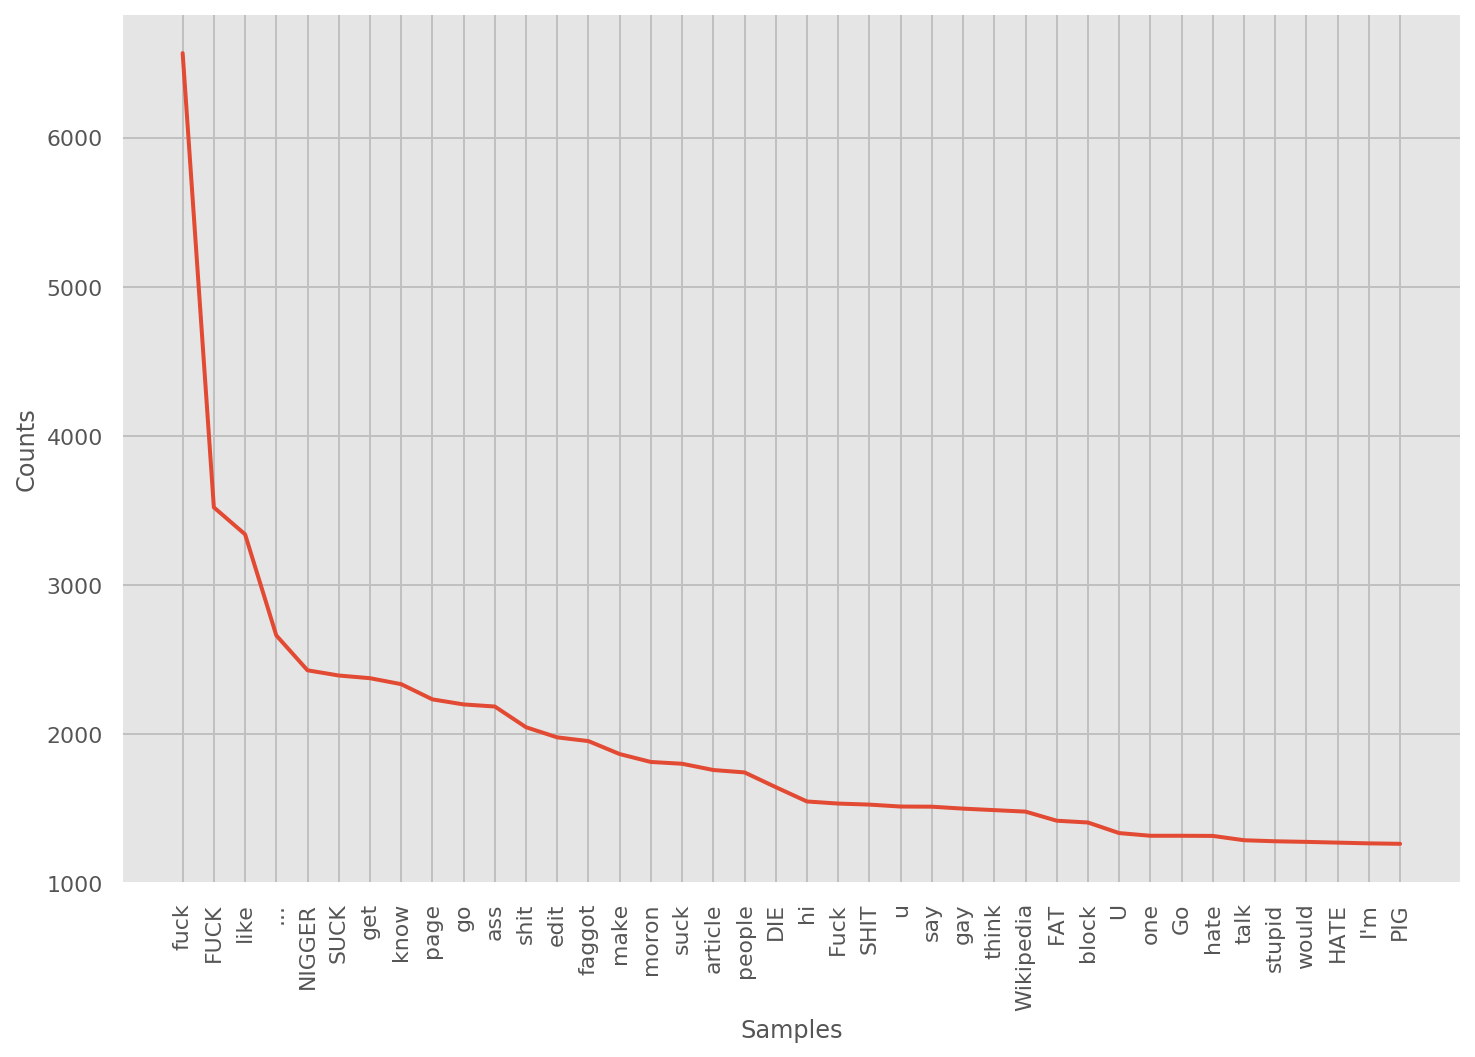

In [54]:
fd.plot(40)

Text(0, 0.5, 'freq')

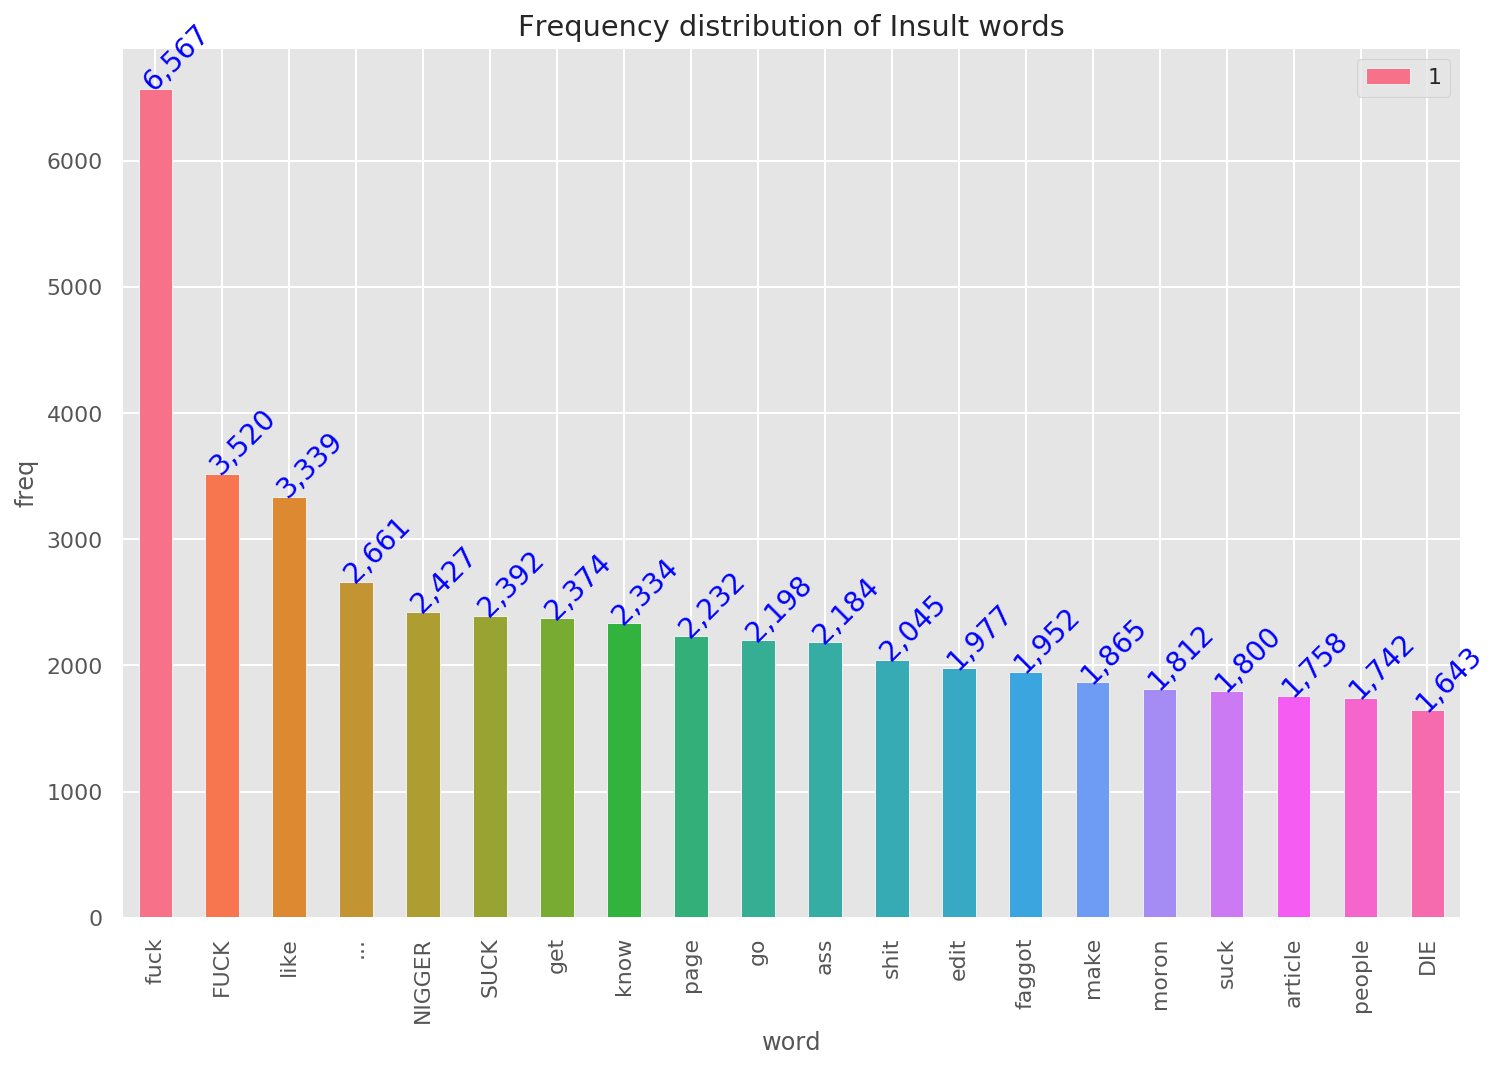

In [65]:
ax = pd.DataFrame(fd.most_common(20)).plot.bar(x=0,y=1,color=sns.color_palette('husl',20))
for p in ax.patches:
    x,y = p.get_x(), p.get_height()
    ax.text(x,y,f'{y:,.0f}',fontsize=14,color='blue',rotation=45)


plt.title('Frequency distribution of Insult words')
plt.xlabel('word')
plt.ylabel('freq')

True

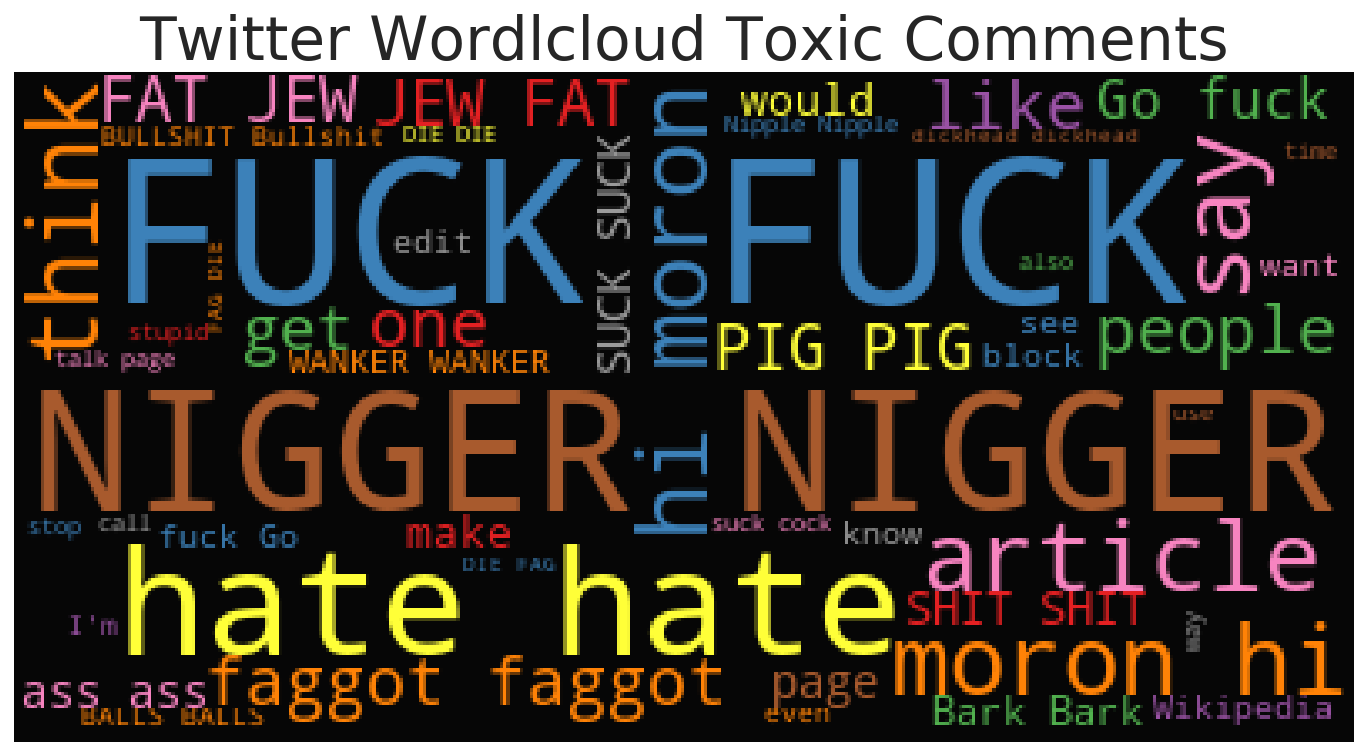

In [72]:
wordcloud_plot(toxic1,'Toxic')

# Tf-idf Vectorization

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(strip_accents='unicode',
                     analyzer='word',
                     ngram_range=(1,1),
                     use_idf=True,
                     smooth_idf=True,
                     sublinear_tf=True,
                     stop_words = 'english')

In [0]:
def txt_arr_to_tfidf(txt_arr):
    tvec_weights = tf.fit_transform(txt_arr)
    weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
    df_weights = pd.DataFrame({'term': tf.get_feature_names(), 'weight': weights})
    df_weights1 = df_weights.sort_values(by='weight', ascending=False).head(10)

    return df_weights1

In [78]:
df_toxic_tfidf = txt_arr_to_tfidf(toxic1)
df_toxic_tfidf


,term,weight
11084,fuck,0.026908
25721,suck,0.009767
24072,shit,0.008288
16023,like,0.008268
29315,wikipedia,0.007847
18544,nigger,0.007502
2556,ass,0.006646
10014,faggot,0.006106
12622,hate,0.005971
19623,page,0.005795


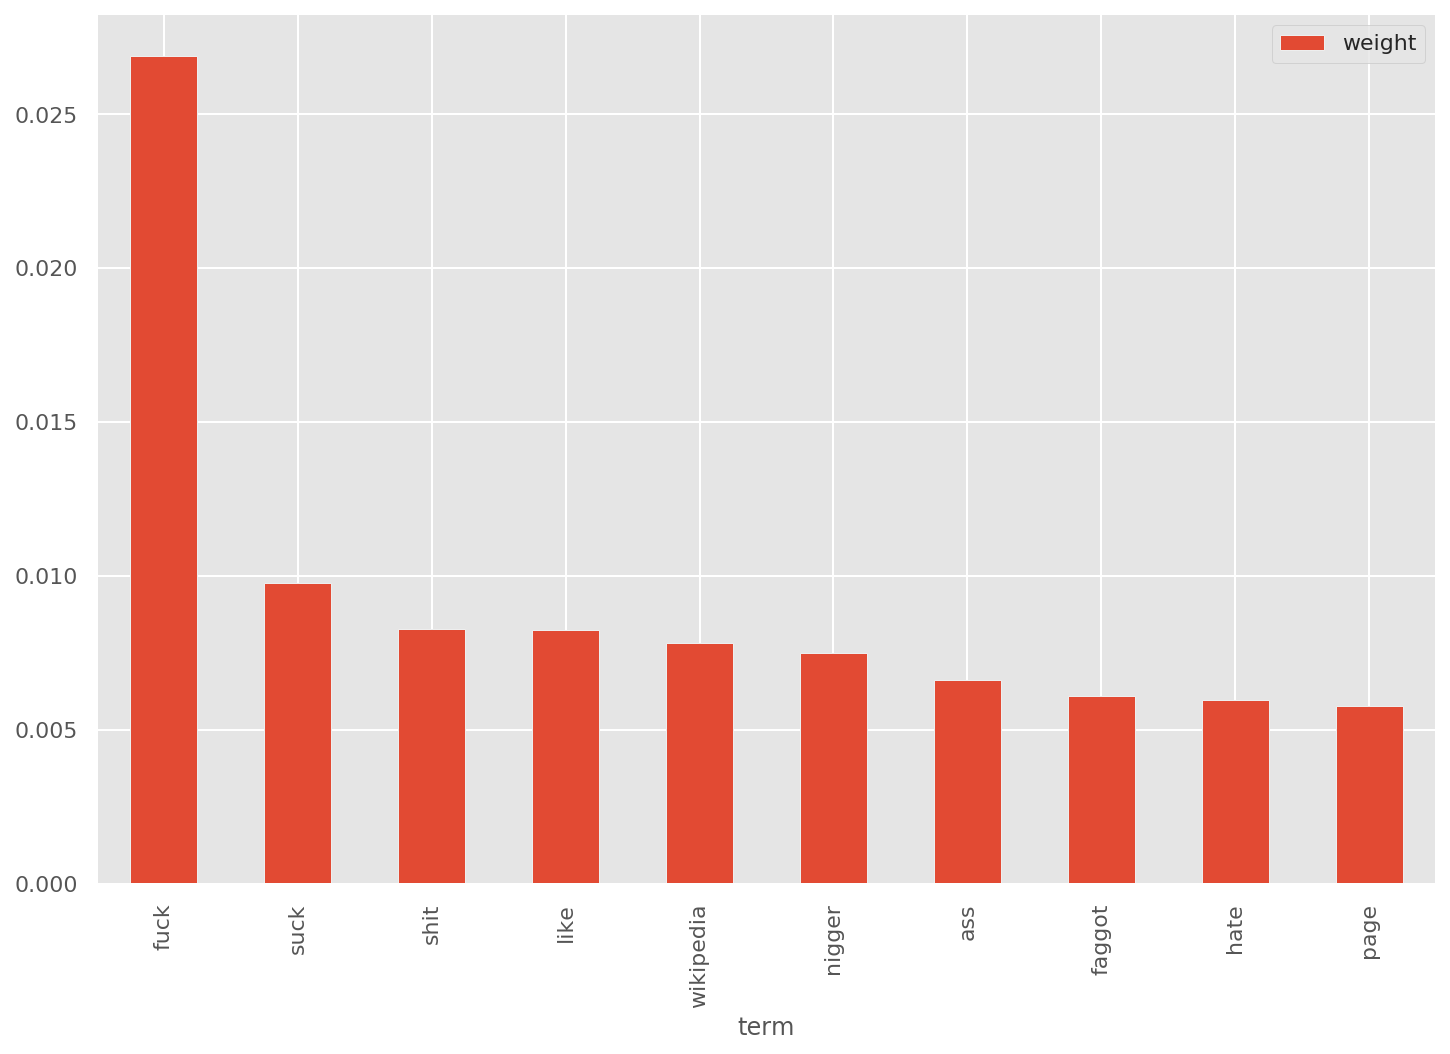

In [79]:
df_toxic_tfidf.plot.bar(x='term',y='weight')